In [32]:
import matlab.engine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from pathlib import Path

In [33]:
eng = matlab.engine.start_matlab()
s = eng.genpath('../Dual-ALM-for-NPMLE')
eng.addpath(s, nargout=0)
eng.addpath('../matlab_codes', nargout=0)

In [34]:
N = [3000, 6000, 10000]
B = 500
m = 20
priors = ['uniform', 'normal', 'beta']

In [35]:
x_cov =  np.array([[0.2, -0.1], [-0.1, 0.2]])
beta = np.array([1.0, 2.0, 1.5, 0.7]).reshape((4,1))
delta =  np.array([0.4, 0.5]).reshape((2,1))
gamma = 2.2

x_cov_m = matlab.double(x_cov)
beta_m = matlab.double(beta)
delta_m = matlab.double(delta)
gamma_m = matlab.double(gamma)

In [36]:
def consistent_plot(b_est_df, title=None):
    fig, axs = plt.subplots(1,4,figsize=(18,4))
    
    for i in range(4):
        axs[i].set_title(f'beta_{i}')
        axs[i].axvline(x=beta[i], color='r')
        sns.kdeplot(data=b_est_df, x=i, hue='n', ax=axs[i])
        
        
    if title:
        fig.suptitle(title)
    return fig

In [37]:
def assess_prior_plot(grid, weight, theta):
    fig, axs = plt.subplots(1,2,figsize=(14,6))
    
    df = pd.DataFrame({
            'grid_0': grid[:,0],
            'grid_1': grid[:,1],
            'weight': weight
    })
    
    for i in range(2):            
            
            axs[i].ecdf(theta[:,i], label='True')
            
            
            df_sort = df.sort_values(f'grid_{i}')
            axs[i].plot(df_sort[f'grid_{i}'], df_sort['weight'].cumsum(), label='NPMLE')
            

            axs[i].set_title(f'theta {i}')
            axs[i].legend()
            axs[i].set_xlim(df_sort[f'grid_{i}'].min(), df_sort[f'grid_{i}'].max())
            
    return fig
        
            

In [38]:
def assess_prior_table(grid, weight, theta):
    
    estimated_theta = pd.Series(
        {'theta_1': grid[:,0] @ weight,
        'theta_2': grid[:,1] @ weight,
        'theta_1^2': grid[:,0]**2 @ weight,
        'theta_2^2': grid[:,1]**2 @ weight,
        'theta_1*theta_2': (grid[:,0]*grid[:,1]) @ weight,
        }
    )

    true_theta = pd.Series(
        {'theta_1': theta[:,0].mean(),
        'theta_2': theta[:,1].mean(),
        'theta_1^2': (theta[:,0]**2).mean(),
        'theta_2^2': (theta[:,1]**2).mean(),
        'theta_1*theta_2': (theta[:,0] * theta[:,1]).mean()
        }
    )

    return pd.DataFrame([estimated_theta, true_theta], index=['estimated', 'true'])
        

In [39]:
def run_exp(prior, run_anyway=False):
    b_est_list = []
    
    title = f'{prior}'
    p = Path('dim2_combinations') / title
    
    if (not p.is_dir()) or (run_anyway):
        
        p.mkdir(exist_ok=True)
        
        for n in N:
            for b in range(B):
                b_est, grid, weight, theta, y, pm = eng.dim2_twostep(n, m, prior, x_cov_m, gamma_m, delta_m, beta_m, nargout=6)
                b_est_series = pd.Series(np.array(b_est).reshape(-1))
                b_est_series['n'] = n 
                b_est_list.append(b_est_series)
        b_est_df = pd.DataFrame(b_est_list)
        
        # store mean
        
        for i in range(len(beta)):
            b_est_df[f'{i}_MSE'] = (b_est_df[i] - beta[i])**2
        
        b_est_df.groupby('n').mean().to_csv( p / 'beta_pm.csv')
        
        
        # store fig
        
        consistent_plt = consistent_plot(b_est_df, title)
        consistent_plt.savefig(p /'consistent.png' )
        
        grid = np.array(grid)
        weight = np.array(weight).reshape(-1)
        theta = np.array(theta)
        
        
        prior_plt = assess_prior_plot(grid, weight, theta)
        prior_plt.savefig(p / 'prior_compare.png' )
        
        prior_table = assess_prior_table(grid, weight, theta)
        prior_table.to_csv(p / 'prior.csv')
        

        

/tmp/ipykernel_2131827/4274122796.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=b_est_df, x=i, hue='n', ax=axs[i])
/tmp/ipykernel_2131827/4274122796.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=b_est_df, x=i, hue='n', ax=axs[i])
/tmp/ipykernel_2131827/4274122796.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=b_est_df, x=i, hue='n', ax=axs[i])
/tmp/ipykernel_2131827/4274122796.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=b_est_df, x=i, hue='n', ax=axs[i])
/tmp/ipykernel_2131827/4274122796.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sn

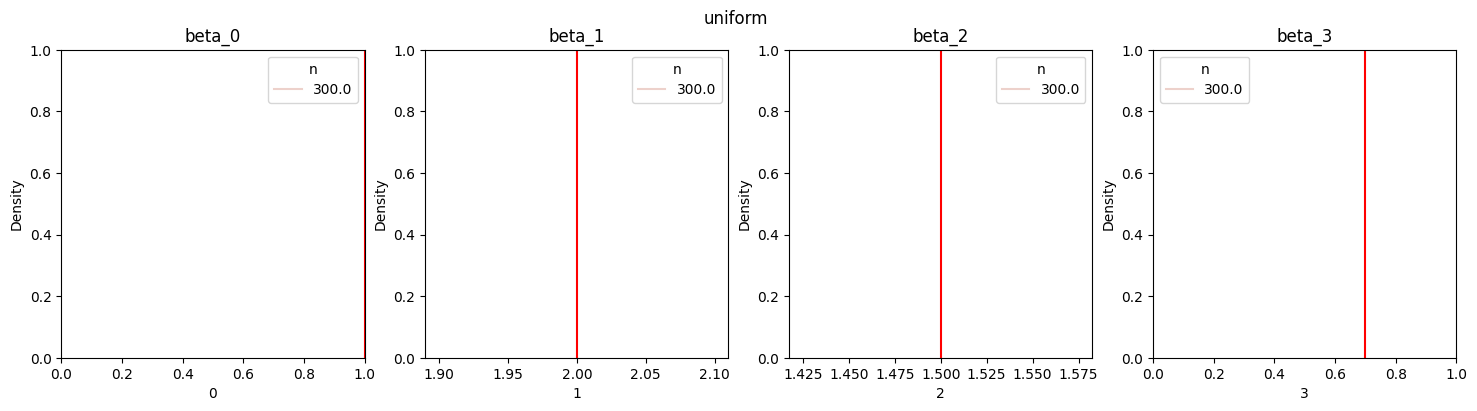

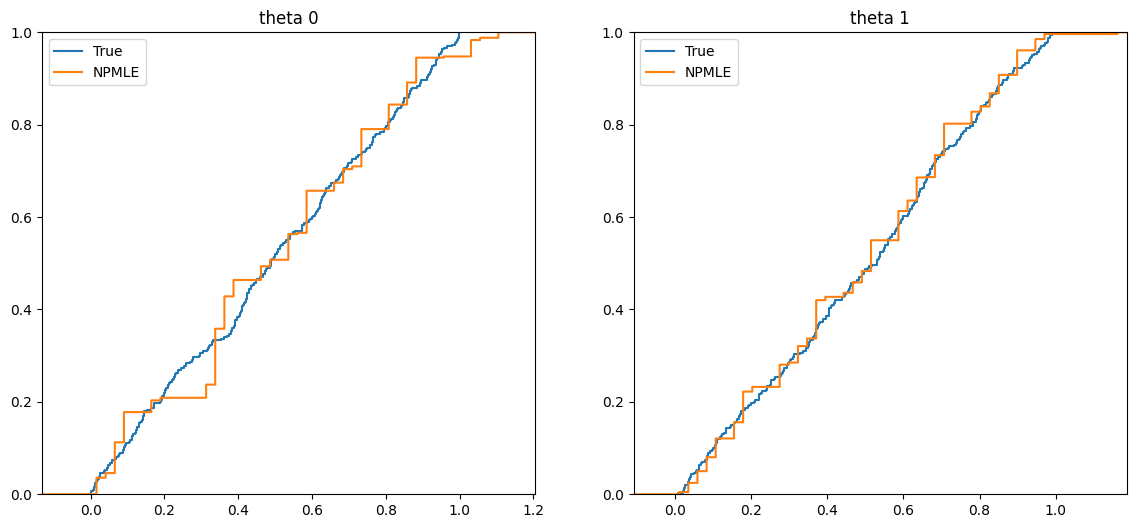

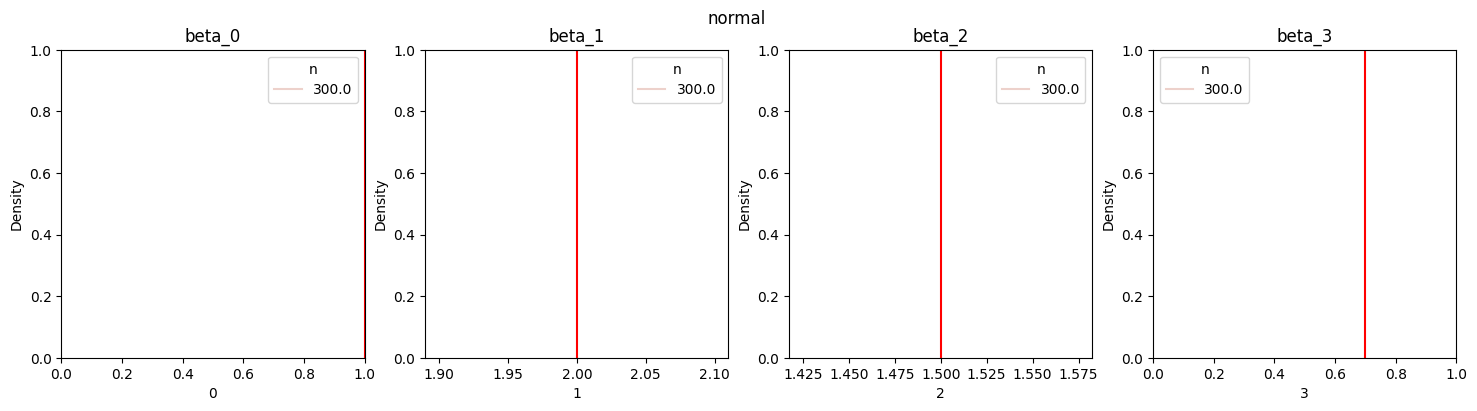

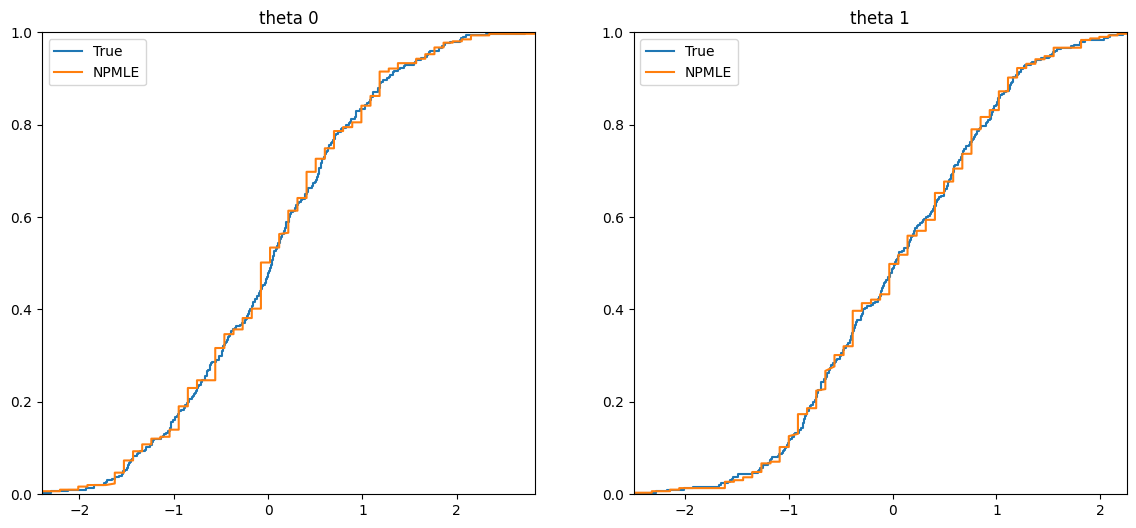

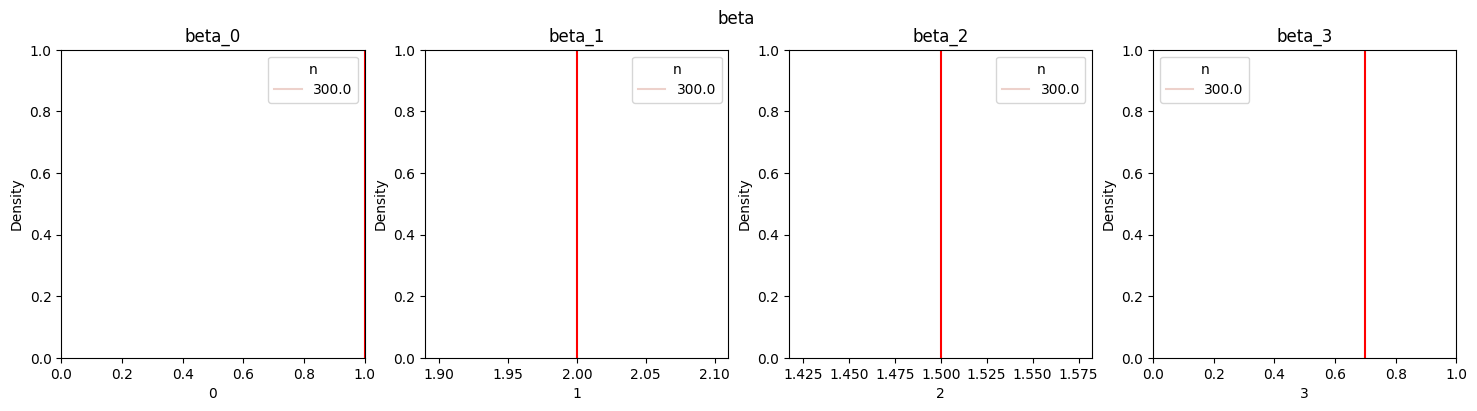

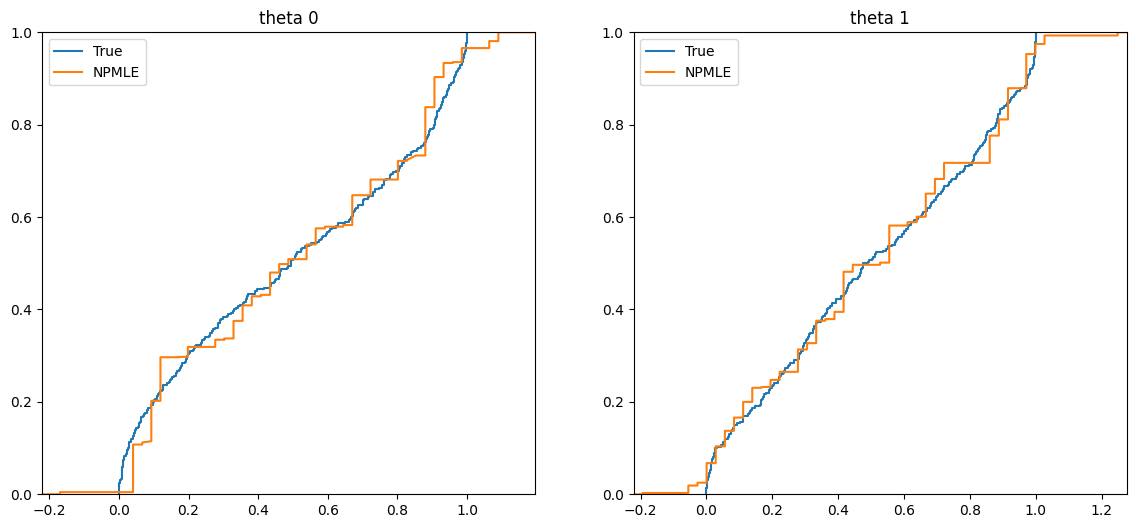

In [40]:
for prior in priors:
    run_exp(prior, True)